In [138]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('zone_data_1A_clustered.csv', nrows=40000)
zone_data_7 = pd.read_csv('zone_data_7_clustered.csv')
zone_data_6 = pd.read_csv('zone_data_6_clustered.csv')

# Separate zone_data_1A into two different DataFrames based on the cluster assignment
zone_data_1A_top = zone_data_1A[zone_data_1A['Cluster'] == 0]
zone_data_1A_bottom = zone_data_1A[zone_data_1A['Cluster'] == 1]

zone_data_7_top = zone_data_7[zone_data_7['Cluster'] == 0]
zone_data_7 = zone_data_7[zone_data_7['Cluster'] == 1]

zone_data_6_top = zone_data_6[zone_data_6['Cluster'] == 1]
zone_data_6 = zone_data_6[zone_data_6['Cluster'] == 0]

# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A_top.copy()
zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6_top.copy()
zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7_top.copy()
zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

print(zone_data_1A_top_sorted)




         Status Application Creation Date Approved / Refused Date  \
15192   Refused                2008-04-28              30/04/2010   
9636    Expired                2009-01-06              26/08/2009   
10589  Recorded                2009-01-10              16/10/2009   
11781  Recorded                2009-01-10              05/10/2009   
2043   Recorded                2009-01-10              09/10/2009   
...         ...                       ...                     ...   
10747  Recorded                2024-12-02              22/02/2024   
8195   Recorded                2024-12-03              16/04/2024   
16325  Recorded                2024-12-03              04/04/2024   
544    Recorded                2024-12-03              21/03/2024   
6287   Recorded                2024-12-04              16/04/2024   

      Recorded / Rejected Date Water Share ID Water System Source Reliability  \
15192               30/04/2010      WEE****03            Goulburn        High   
9636     

In [139]:
# Load the data
file_path = '../GET_WATER_DATA_ONLINE/DailyMeanTempData.csv'
tempData = pd.read_csv(file_path, parse_dates=['Time'], index_col='Time')

from sklearn.impute import SimpleImputer

# Impute missing values with the median of each column
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(tempData), columns=tempData.columns, index=tempData.index)

print(data_imputed)

# Group imputed data by 'Time', aggregate, and convert 'Time' to ordinal
daily_tempData = data_imputed.groupby(data_imputed.index).mean().reset_index()
daily_tempData['Time_ordinal'] = pd.to_datetime(daily_tempData['Time']).apply(lambda x: x.toordinal())

# Merge the DataFrames on the ordinal date column
combined_data = pd.merge(zone_data_1A_top_sorted, daily_tempData, left_on='Create_date_ordinal', right_on='Time_ordinal', how='inner')

print(combined_data)

# Export the combined data to a CSV file
combined_data.to_csv('combined_data.csv', index=False)


                           2122518  2122711  2122713  2122725  215209  \
Time                                                                    
2022-01-01 00:00:00+10:00    15.09    22.50    21.39    22.42 -7999.0   
2022-01-01 00:30:00+10:00    15.09    16.76    15.09    15.06 -7999.0   
2022-01-02 00:00:00+10:00    15.09    23.76    22.43    24.98 -7999.0   
2022-01-02 00:30:00+10:00    15.09    16.76    15.09    15.06 -7999.0   
2022-01-03 00:00:00+10:00    15.09    24.51    23.19    25.28 -7999.0   
...                            ...      ...      ...      ...     ...   
2023-12-30 00:00:00+10:00     0.00    20.64    15.09    15.06 -7999.0   
2023-12-30 00:30:00+10:00    15.09    16.76    15.09    15.06 -7999.0   
2023-12-31 00:00:00+10:00     0.00    20.67    15.09    15.06 -7999.0   
2023-12-31 00:30:00+10:00    15.09    16.76    15.09    15.06 -7999.0   
2024-01-01 00:00:00+10:00     0.00    20.53    15.09    15.06 -7999.0   

                           215237B  219025  219067

In [140]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)



# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]
x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(x)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Combine with original data
finalDf = pd.concat([principalDf, combined_data[['Create_date']]], axis=1)

# Display the results of the PCA
print(finalDf.head())


[[-0.41784605 -0.42980507  0.07390308 ...  0.05539702 -0.74774817
  -1.68472057]
 [-0.41784605 -0.42980507  0.07390308 ...  0.05539702 -0.07228019
  -1.68472057]
 [-0.42975044 -0.42980507  0.07390308 ...  0.05539702 -0.74774817
  -1.68472057]
 ...
 [-0.42975044  1.94857237  0.07390308 ...  0.05539702 -0.07228019
   1.75392526]
 [-0.41784605 -0.90548056 -4.82552248 ...  0.05539702 -0.07228019
   1.75392526]
 [-0.41784605 -0.90548056  0.07390308 ...  0.05539702 -0.07228019
   1.75392526]]
Explained Variance Ratio: [0.67446877 0.05437884]
   principal component 1  principal component 2 Create_date
0              34.463886               0.216967  2022-01-02
1              -0.329516               9.213759  2022-01-02
2              34.463884               0.216967  2022-01-02
3              -0.329517               9.213759  2022-01-02
4              34.466541               0.224134  2022-01-02


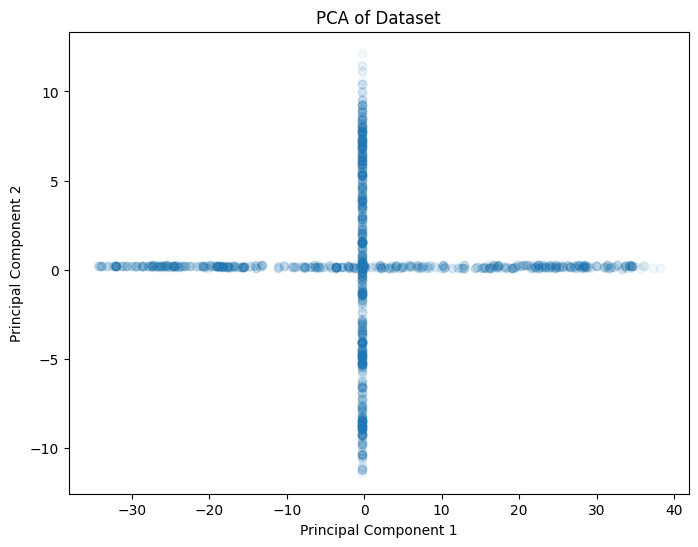

Explained Variance Ratio: [0.67446877 0.05437884]
   principal component 1  principal component 2 Create_date
0              34.463886               0.216967  2022-01-02
1              -0.329516               9.213759  2022-01-02
2              34.463884               0.216967  2022-01-02
3              -0.329517               9.213759  2022-01-02
4              34.466541               0.224134  2022-01-02


In [141]:
# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], alpha=0.05)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(finalDf.head())